<a href="https://colab.research.google.com/github/deansaco/handwrittendigits/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q -U keras_tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


In [3]:
import os
import pickle
import math
import random
import csv
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import keras_tuner as kt

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Conv2D, Dropout, ReLU, MaxPool2D, Flatten

print('All modules imported.')

All modules imported.


In [4]:
#mount zip file for google colab gpu use
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

# Location of Zip File
drive_path = '/gdrive/MyDrive/Traffic-Sign-Classifier-master.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'Traffic-Sign-Classifier-master.zip'

Mounted at /gdrive


Dataset details:
*   The size of training set is: 34799
*   The size of the validation set is: 4410
*   The size of test set is: 12630
*   The shape of a traffic sign image is: (32, 32 ,3)
*   number of classes=43


In [5]:
# load the preprocessed data
pickle_file = '/content/Traffic-Sign-Classifier-master/traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

#normalize pixel values to be between 0-1
X_train=X_train/255.0
X_valid=X_valid/255.0
X_test =X_test/255.0

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames), 'sign classes')
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43 sign classes
Data loaded.


In [6]:
#convert output into one hot encoded vector
y_train = tf.one_hot(y_train, 43)
y_valid = tf.one_hot(y_valid, 43)
y_test = tf.one_hot(y_test, 43)

Visualize sample of dataset:

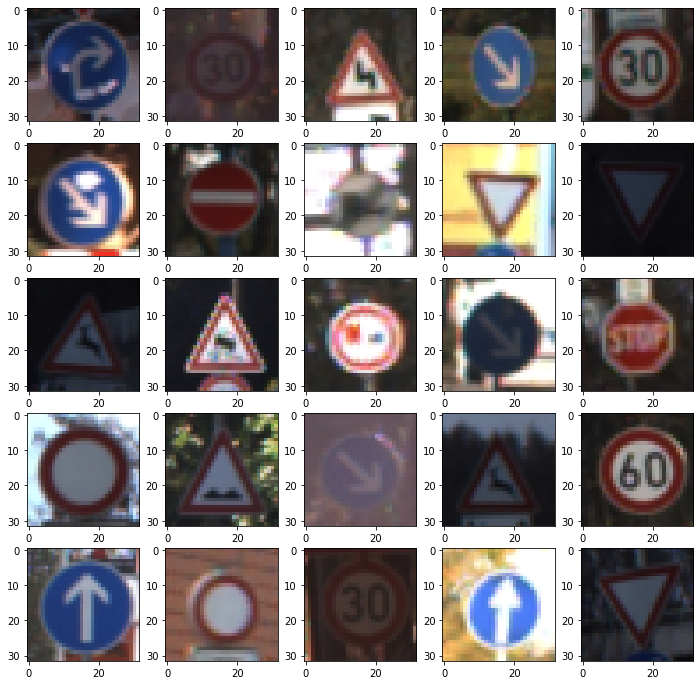

In [7]:
plt.figure(figsize=(12,12))
# plot first few images
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
#Define model architecture: LeNet

Model Definition: LeNet Architecture

**Layer 1: Convolutional**
*   Input = 32x32x3. Output = 28x28x6.
*   Filters (number of output filters) = 6
*   kernel size (height and width of conv window) =5
*   activation function = relu

**Max Pooling**
* Input = 28x28x6. Output = 14x14x6.
* pool size = 2x2 window, strides = moves 2 in x and 2 in y for each pool step

**Layer 2: Convolutional**
* Input = 14x14x6. Output = 10x10x16.
* filters = 16 
* kernel_size=5
* activation=relu

**Max Pooling**
* Input = 10x10x16. Output = 5x5x16.
* pool size = 2x2 window, strides = moves 2 in x and 2 in y for each pool step

* Flatten. Input = 5x5x16. Output = 400.


**Layer 3: Fully Connected (dense)**
* Input = 400. Output = 120.
* dropout: disconnect 30% of connections to reduce overfitting
* activation=relu


**Layer 4: Fully Connected (dense)**
* Input = 120. Output = 84.
* dropout: disconnect 30% of connections to reduce overfitting
* activation=relu

**Layer 5: Fully Connected (dense)**
* Input = 84. Output = 43.


In [8]:
def create_model(hp):
    LeNetModel= tf.keras.Sequential(layers=[Conv2D(6,5, activation= ReLU()), 
                            MaxPool2D([2, 2], [2, 2]),
                            Conv2D(16,5, activation= ReLU()),
                            MaxPool2D([2, 2], [2, 2]),
                            Flatten(),
                            Dense(120, activation= ReLU()),
                            Dropout(0.3),
                            Dense(84, activation= ReLU()),
                            Dropout(0.3),
                            Dense(43)
                           ])
    
    #use keras tuner to find learning rate that results in highest test accuracy
    hp_learning_rate=hp.Choice('learning_rate', values =[1e-2, 1e-3, 1e-4])
    #BATCH_SIZE = 128 #number of samples in an epoch
    #loss function: categorical cross-entropy for multi-class classification
    #optimizer: stochastic grad. descent
    opt= tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, name='SGD')
    loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    LeNetModel.compile(optimizer=opt, loss=loss_function, metrics=['acc'])
    return LeNetModel

In [9]:
tuner =kt.Hyperband(create_model,
                    objective='val_acc',
                    max_epochs = 50)

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [11]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[stop_early])

best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer is
{best_hps.get('learning_rate')}.
""")

Trial 3 Complete [00h 00m 19s]
val_acc: 0.4574030041694641

Best val_acc So Far: 0.4574030041694641
Total elapsed time: 00h 01m 23s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal learning rate for the optimizer is
0.01.



In [15]:
#use keras_tuner to find best epoch number choice
model=tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, 
                         epochs=60, 
                         batch_size=128, 
                         validation_data=(X_test, y_test))

val_acc_per_epoch = history.history['val_acc']
best_epoch=val_acc_per_epoch.index(max(val_acc_per_epoch))+1
print('Best epoch: %d'% (best_epoch,))

Epoch 1/60
272/272 [==============================] - 4s 12ms/step - loss: 3.6893 - acc: 0.0485 - val_loss: 3.5560 - val_acc: 0.0960
Epoch 2/60
272/272 [==============================] - 3s 11ms/step - loss: 3.5463 - acc: 0.0634 - val_loss: 3.4715 - val_acc: 0.1199
Epoch 3/60
272/272 [==============================] - 3s 11ms/step - loss: 3.4489 - acc: 0.0875 - val_loss: 3.3495 - val_acc: 0.1523
Epoch 4/60
272/272 [==============================] - 3s 10ms/step - loss: 3.2853 - acc: 0.1434 - val_loss: 3.0653 - val_acc: 0.2439
Epoch 5/60
272/272 [==============================] - 3s 10ms/step - loss: 2.9849 - acc: 0.2347 - val_loss: 2.6814 - val_acc: 0.3442
Epoch 6/60
272/272 [==============================] - 3s 10ms/step - loss: 2.6398 - acc: 0.3193 - val_loss: 2.2931 - val_acc: 0.4163
Epoch 7/60
272/272 [==============================] - 3s 11ms/step - loss: 2.2956 - acc: 0.3892 - val_loss: 2.0067 - val_acc: 0.4567
Epoch 8/60
272/272 [==============================] - 3s 11ms/step - 

**Plot Test Accuracy and Train Accuracy vs # epochs**

395/395 - 1s - loss: 0.4380 - acc: 0.9010 - 1s/epoch - 3ms/step
Test Accuracy: 90.10292887687683


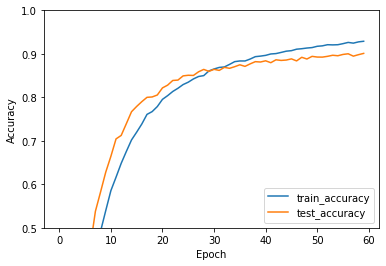

In [16]:
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

      
print(f'Test Accuracy:', 100*test_accuracy)

As # of epochs increase, accuaracy increases but overfitting increases

In [17]:
hypermodel=tuner.hypermodel.build(best_hps)

checkpoint_path="LeNet_dropout=0.3/cp.ckpt"
checkpoint_dir=os.path.dirname(checkpoint_path)

cp_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                save_weights_only=True,
                                                verbose=1)


#fit model
history = hypermodel.fit(X_train, y_train, 
                          epochs=best_epoch, 
                          batch_size=128, 
                          validation_data=(X_test, y_test),
                          callbacks=[cp_callback])



Epoch 1/60
267/272 [============================>.] - ETA: 0s - loss: 3.6674 - acc: 0.0585
Epoch 00001: saving model to LeNet_dropout=0.3/cp.ckpt
272/272 [==============================] - 4s 12ms/step - loss: 3.6659 - acc: 0.0587 - val_loss: 3.5271 - val_acc: 0.0842
Epoch 2/60
267/272 [============================>.] - ETA: 0s - loss: 3.4690 - acc: 0.0990
Epoch 00002: saving model to LeNet_dropout=0.3/cp.ckpt
272/272 [==============================] - 3s 10ms/step - loss: 3.4679 - acc: 0.0991 - val_loss: 3.2831 - val_acc: 0.1997
Epoch 3/60
268/272 [============================>.] - ETA: 0s - loss: 3.2125 - acc: 0.1702
Epoch 00003: saving model to LeNet_dropout=0.3/cp.ckpt
272/272 [==============================] - 3s 11ms/step - loss: 3.2100 - acc: 0.1709 - val_loss: 2.9307 - val_acc: 0.2755
Epoch 4/60
269/272 [============================>.] - ETA: 0s - loss: 2.8888 - acc: 0.2418
Epoch 00004: saving model to LeNet_dropout=0.3/cp.ckpt
272/272 [==============================] - 3s 11ms

In [22]:
#save model
hypermodel.load_weights(checkpoint_path)
test_loss, test_accuracy = hypermodel.evaluate(X_test, y_test)
valid_loss, valid_accuracy = hypermodel.evaluate(X_valid, y_valid)
train_loss, train_accuracy =hypermodel.evaluate(X_train, y_train)


print("restored model, test accuracy: {:5.2f}%".format(100*test_accuracy))
print("restored model, validation accuracy: {:5.2f}%".format(100*valid_accuracy))

print("restored model, train accuracy: {:5.2f}%".format(100*train_accuracy))





1088/1088 [==============================] - 5s 4ms/step - loss: 0.0697 - acc: 0.9836
restored model, test accuracy: 91.05%
restored model, validation accuracy: 92.68%
restored model, train accuracy: 98.36%


**Evaluate LeNet classifier on first ten images in test set:**

predicted sign: Go straight or right


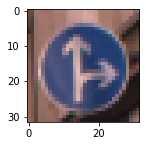

real sign: Go straight or right




predicted sign: No passing for vehicles over 3.5 metric tons


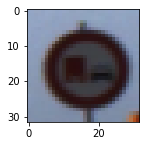

real sign: No passing for vehicles over 3.5 metric tons




predicted sign: General caution


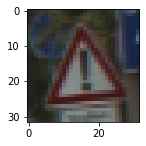

real sign: General caution




predicted sign: Speed limit (120km/h)


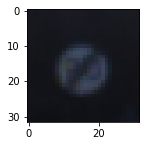

real sign: End of speed limit (80km/h)




predicted sign: Speed limit (100km/h)


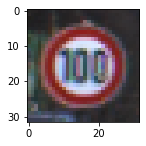

real sign: Speed limit (100km/h)




predicted sign: Speed limit (50km/h)


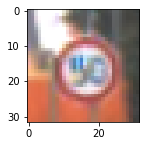

real sign: Speed limit (50km/h)




predicted sign: Dangerous curve to the right


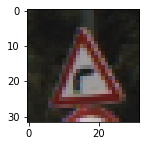

real sign: Dangerous curve to the right




predicted sign: Vehicles over 3.5 metric tons prohibited


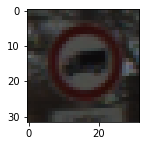

real sign: Vehicles over 3.5 metric tons prohibited




predicted sign: No passing


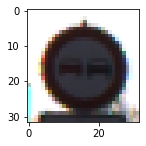

real sign: No passing






In [18]:
#test_image = np.array(X_train[0]).reshape(-1, 32, 32,3)
#test_image=X_train[11]


for i in range(1,10):
    test_image = X_test[i]
    array=np.expand_dims(test_image, axis=0)
    prediction = hypermodel.predict(array)
    prediction= (np.argmax(prediction))
    print("predicted sign:", signnames[prediction])    
    test_label= y_test[i]
    arr=np.expand_dims(test_label, axis=0)
    truth= (np.argmax(arr))
    plt.figure(figsize=(12,12))
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(test_image, cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()
    print("real sign:", signnames[truth])
    print('\n')
    print('\n')


In [19]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
hypermodel.load_weights(latest)

In [21]:
#restore saved model
test_loss, test_accuracy = hypermodel.evaluate(X_test, y_test)
print("restored model, test accuracy: {:5.2f}%".format(100*test_accuracy))



395/395 [==============================] - 2s 4ms/step - loss: 0.4531 - acc: 0.9105
restored model, test accuracy: 91.05%
